In [1]:
import os

import joblib
import matplotlib.pyplot as pp
import numpy as np

MODELS_DIR = os.path.join("models", "03")
os.makedirs(MODELS_DIR, exist_ok=True)


In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)


In [3]:
X, y = mnist["data"].astype(int), mnist["target"].astype(int)
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]


# 1

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()
param_grid = {"n_neighbors": [2, 3, 5, 10], "weights": ["uniform", "distance"]}
grid_search = GridSearchCV(knn_clf, param_grid, scoring="accuracy", cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [8]:
# joblib.dump(grid_search, os.path.join(MODELS_DIR, "knn_clf_grid_search.pkl"), 3)
grid_search = joblib.load(os.path.join(MODELS_DIR, "knn_clf_grid_search.pkl"))


In [9]:
grid_search.best_estimator_


KNeighborsClassifier(n_neighbors=3, weights='distance')

In [15]:
grid_search.best_score_


0.9711166666666665

In [6]:
from sklearn.metrics import accuracy_score

best_knn_clf = grid_search.best_estimator_
y_pred = best_knn_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.9717

# 2

In [4]:
def shift_image(image, vert_shift, hor_shift):

    array = image.reshape(28, 28)
    new_array = np.zeros(array.shape)

    to_slice = (
        slice(max(0, vert_shift), min(array.shape[0], array.shape[0] + vert_shift)),
        slice(max(0, hor_shift), min(array.shape[1], array.shape[1] + hor_shift)),
    )

    from_slice = (
        slice(max(0, -vert_shift), min(array.shape[0], array.shape[0] - vert_shift)),
        slice(max(0, -hor_shift), min(array.shape[1], array.shape[1] - hor_shift)),
    )

    new_array[to_slice] = array[from_slice]

    return new_array.flatten()


Text(0.5, 1.0, 'Shifted by (6, 2)')

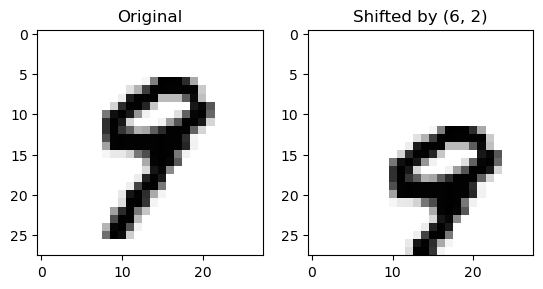

In [88]:
import numpy.random as rd

index = rd.randint(0, X.shape[0])
original = X[index]
vert_shift = rd.randint(-28, 29)
hor_shift = rd.randint(-28, 29)
shifted = shift_image(original, vert_shift, hor_shift)

fig, axes = pp.subplots(1, 2)
axes[0].imshow(original.reshape(28, 28), cmap="binary")
axes[1].imshow(shifted.reshape(28, 28), cmap="binary")
axes[0].set_title("Original")
axes[1].set_title("Shifted by {}".format((vert_shift, hor_shift)))


In [5]:
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
num_dups = len(directions) + 1

X_train_expanded = np.concatenate(
    np.apply_along_axis(lambda x: [x] + [shift_image(x, *d) for d in directions], 1, X_train)
)
y_train_expanded = np.concatenate(list(map(lambda y: num_dups * [y], y_train)))


In [6]:
grid_search = joblib.load(os.path.join(MODELS_DIR, "knn_clf_grid_search.pkl"))


In [7]:
from sklearn.metrics import accuracy_score

best_knn_clf_2 = grid_search.best_estimator_
best_knn_clf_2.fit(X_train_expanded, y_train_expanded)
y_pred_2 = best_knn_clf_2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_2)


In [8]:
accuracy


0.9763

In [9]:
joblib.dump(best_knn_clf_2, os.path.join(MODELS_DIR, "best_knn_clf_expanded.pkl"), 3)


['models/03/best_knn_clf_expanded.pkl']

# 3. Titanic

In [2]:
import os

import pandas as pd


In [3]:
TITANIC_DIR = "titanic"


In [4]:
# Prepare data for the training/predicting.
def prep_data(dataframe, y_col, cat_cols, drop_cols, fillna_dict):

    # Create dummy columns for categorical variables, replace nan values, and drop undesired
    # columns. The old categorical columns are dropped as well.
    prepared = (
        pd.concat([dataframe] + [pd.get_dummies(dataframe[col]) for col in cat_cols], axis=1)
        .fillna(fillna_dict)
        .drop(cat_cols + drop_cols, axis=1)
    )

    # If no column is specified for the labels, there are only feature values.
    if y_col is None:
        return prepared

    # Otherwise, split the dataframe in features and labels.
    X = prepared.drop(y_col, axis=1)
    y = prepared[y_col]

    return X, y


In [5]:
# Names for the label column, categorical columns, and columns to remove from the data.
y_col = "Survived"
cat_cols = ["Sex"]
drop_cols = ["PassengerId", "Name", "Age", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"]


In [6]:
df_train = pd.read_csv(os.path.join(TITANIC_DIR, "train.csv"))


In [7]:
# Prepare training data set.
fillna_train = {"Age": df_train["Age"].median(), "Fare": df_train["Fare"].mean()}
X_train, y_train = prep_data(df_train, y_col, cat_cols, drop_cols, fillna_train)


In [8]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rfc_param_distribs = {
    "n_estimators": randint(1, 201),
    "max_features": randint(1, X_train.shape[1] + 1),
}

# Use random search to find a random forest classifier with high accuracy.
rfc_random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    rfc_param_distribs,
    n_iter=50,
    scoring="accuracy",
    cv=20,
    random_state=0,
    return_train_score=True,
)

rfc_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=20, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3d235a6c50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3d2ada9cf0>},
                   random_state=0, return_train_score=True, scoring='accuracy')

In [9]:
df_test = pd.read_csv(os.path.join(TITANIC_DIR, "test.csv"))


In [10]:
# Prepare test data.
fillna_test = {"Age": df_test["Age"].median(), "Fare": df_test["Fare"].mean()}
X_test = prep_data(df_test, None, cat_cols, drop_cols, fillna_test)


In [11]:
# Evaluate the best random forest classifier on the test feature values.
best_rfc = rfc_random_search.best_estimator_
y_pred = best_rfc.predict(X_test)


In [12]:
# Make new dataframe containing the predictions of survival for each passenger in the test data.
df_pred = df_test[["PassengerId"]].copy()
df_pred["Survived"] = y_pred


In [13]:
# Save predictions as a CSV file.
df_pred.to_csv(os.path.join(TITANIC_DIR, "titanic_predictions.csv"), index=False)
